# Single-image food volume estimation
Using a  monocular depth estimation network and a segmentation network, we will estimate the volume of the food displayed in the input image.

In [3]:
import sys
import json
from keras.models import Model, model_from_json
from food_volume_estimation.volume_estimator import VolumeEstimator
from food_volume_estimation.depth_estimation.custom_modules import *
from food_volume_estimation.food_segmentation.food_segmentator import FoodSegmentator
import matplotlib.pyplot as plt
from pyntcloud import PyntCloud

# # Paths to model archiecture/weights
# depth_model_architecture = '../models/fine_tune_food_videos/monovideo_fine_tune_food_videos.json'
# depth_model_weights = '../models/fine_tune_food_videos/monovideo_fine_tune_food_videos.h5'
# segmentation_model_weights = '../models/segmentation/mask_rcnn_food_segmentation.h5'

In [4]:
# Paths to model archiecture/weights
depth_model_architecture = 'C:\\Users\\Bisht\\OneDrive\\Desktop\\python\\volume_estimation\\models\\monovideo_fine_tune_food_videos.json'
depth_model_weights = 'C:\\Users\\Bisht\\OneDrive\\Desktop\\python\\volume_estimation\\models\\monovideo_fine_tune_food_videos.h5'
segmentation_model_weights = 'C:\\Users\\Bisht\\OneDrive\\Desktop\\python\\volume_estimation\\models\\mask_rcnn_food_segmentation.h5'


In [5]:
# Create estimator object and intialize
estimator = VolumeEstimator(arg_init=False)
with open(depth_model_architecture, 'r') as read_file:
    custom_losses = Losses()
    objs = {'ProjectionLayer': ProjectionLayer,
            'ReflectionPadding2D': ReflectionPadding2D,
            'InverseDepthNormalization': InverseDepthNormalization,
            'AugmentationLayer': AugmentationLayer,
            'compute_source_loss': custom_losses.compute_source_loss}
    model_architecture_json = json.load(read_file)
    estimator.monovideo = model_from_json(model_architecture_json, custom_objects=objs)
estimator._VolumeEstimator__set_weights_trainable(estimator.monovideo, False)
estimator.monovideo.load_weights(depth_model_weights)
estimator.model_input_shape = estimator.monovideo.inputs[0].shape.as_list()[1:]
depth_net = estimator.monovideo.get_layer('depth_net')
estimator.depth_model = Model(inputs=depth_net.inputs, outputs=depth_net.outputs, name='depth_model')
print('[*] Loaded depth estimation model.')

# Depth model configuration
MIN_DEPTH = 0.01
MAX_DEPTH = 10
estimator.min_disp = 1 / MAX_DEPTH
estimator.max_disp = 1 / MIN_DEPTH
estimator.gt_depth_scale = 0.35 # Ground truth expected median depth

# Create segmentator object
estimator.segmentator = FoodSegmentator(segmentation_model_weights)

# Set plate adjustment relaxation parameter
estimator.relax_param = 0.01

[*] VolumeEstimator not initialized.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use the `axis` argument instead
Instructions for updating:
Use tf.cast instead.
[*] Loaded depth estimation model.
[*] Loading segmentation model weights C:\Users\Bisht\OneDrive\Desktop\python\volume_estimation\models\mask_rcnn_food_segmentation.h5


[*] Creating intrinsics matrix from given FOV: 70


C:\Users\Bisht\OneDrive\Desktop\python\volume_estimation\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:84: RuntimeWarning: invalid value encountered in double_scalars
  cab_x = (mb[1] - tb * mb[0] - ma[1] + ta * ma[0]) / (ta - tb)
C:\Users\Bisht\OneDrive\Desktop\python\volume_estimation\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:85: RuntimeWarning: invalid value encountered in double_scalars
  cab_y = (ta * mb[1] - tb * ma[1] + ta * tb * (ma[0] - mb[0])) / (ta - tb)
C:\Users\Bisht\OneDrive\Desktop\python\volume_estimation\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:84: RuntimeWarning: divide by zero encountered in double_scalars
  cab_x = (mb[1] - tb * mb[0] - ma[1] + ta * ma[0]) / (ta - tb)
C:\Users\Bisht\OneDrive\Desktop\python\volume_estimation\food_volume_estimation\ellipse_detection\ellipse_center_estimator.py:85: RuntimeWarning: divide by zero encountered in double_scalars
  cab_y = (ta * mb[1] - tb * ma[1]

[*] Ellipse parameters: (105.95259857177734, 52.613243103027344, 72.5, 27.0959595959596, -0.02632619542114356)
[*] Found 1 food object(s) in image.
[*] Estimated plane parameters (w0,w1,w2,w3): [0.3081814904844431, 0.09387953482133873, -0.2535639723256155, -0.9627522759672831]
[*] Estimated volume: 1.1599836796387535 L


<IPython.core.display.Javascript object>


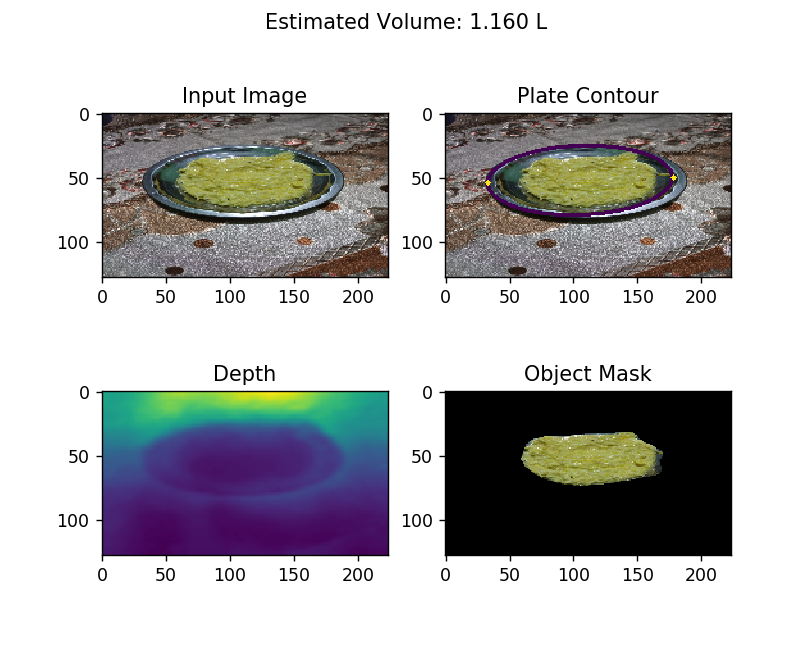

<IPython.core.display.Javascript object>


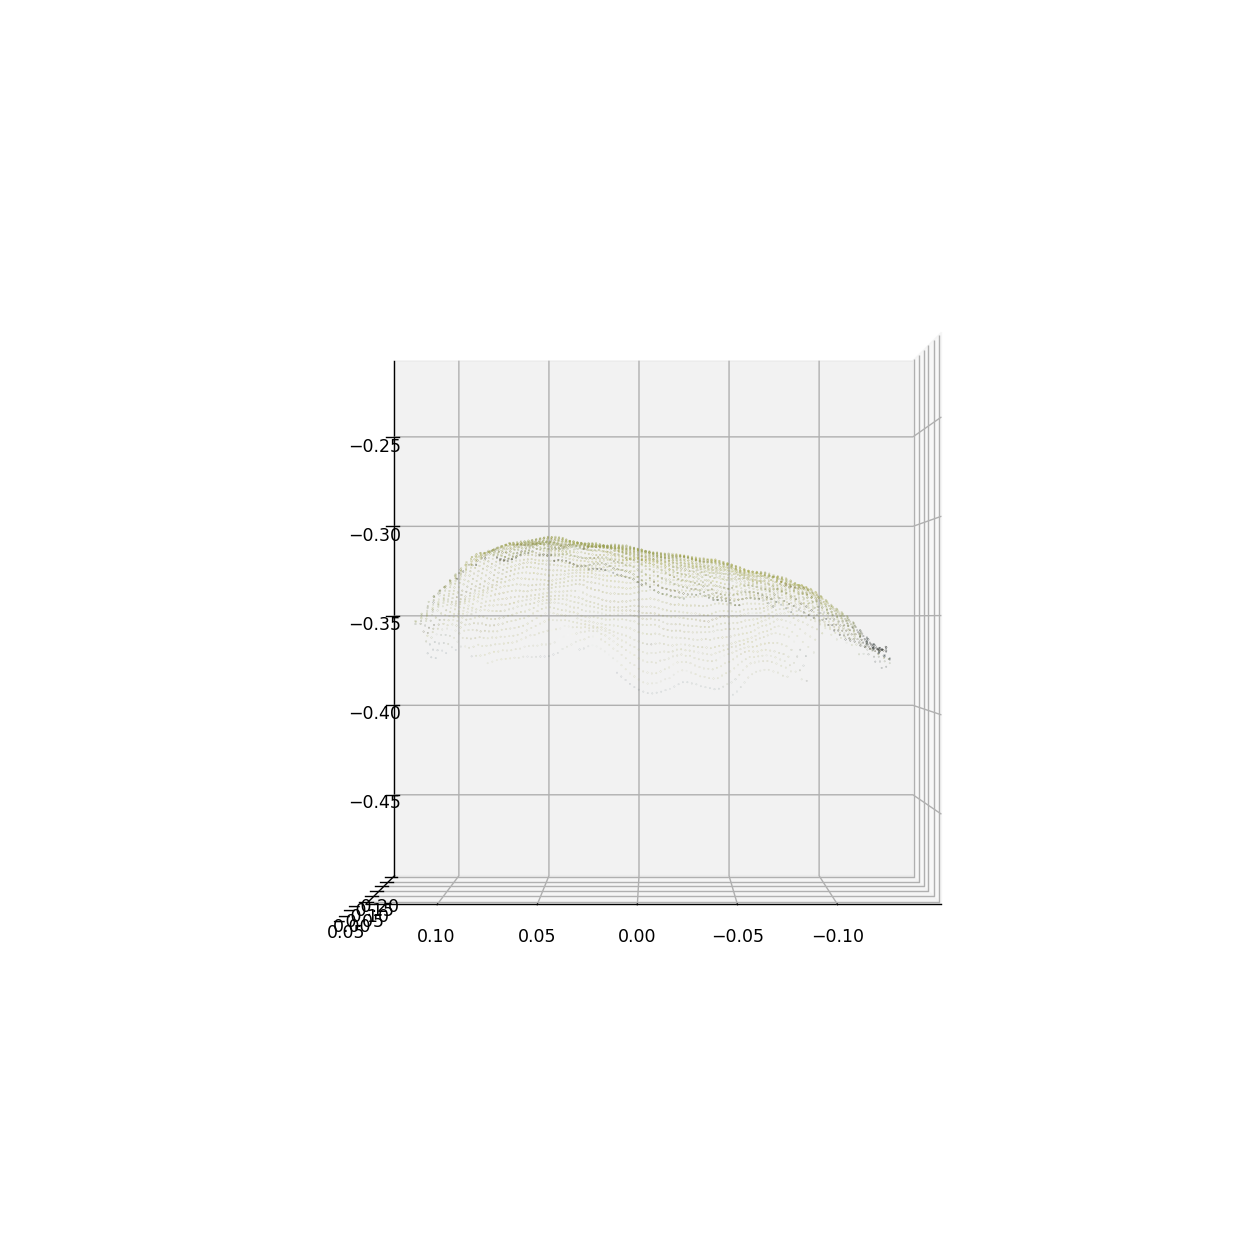

<IPython.core.display.Javascript object>


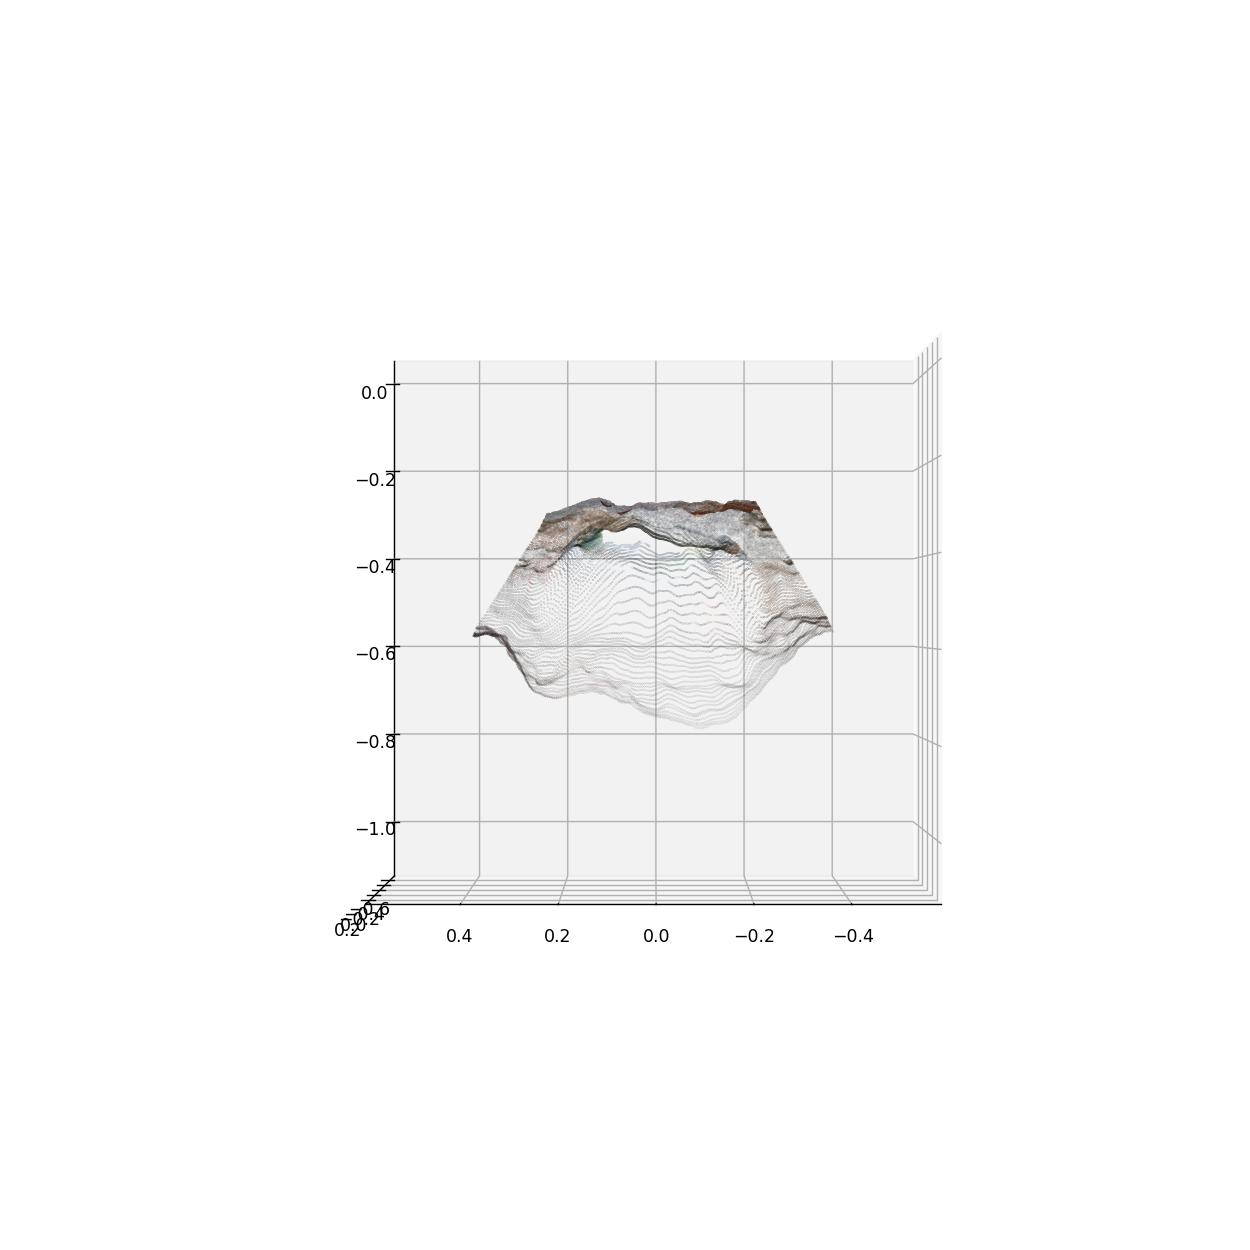

<IPython.core.display.Javascript object>


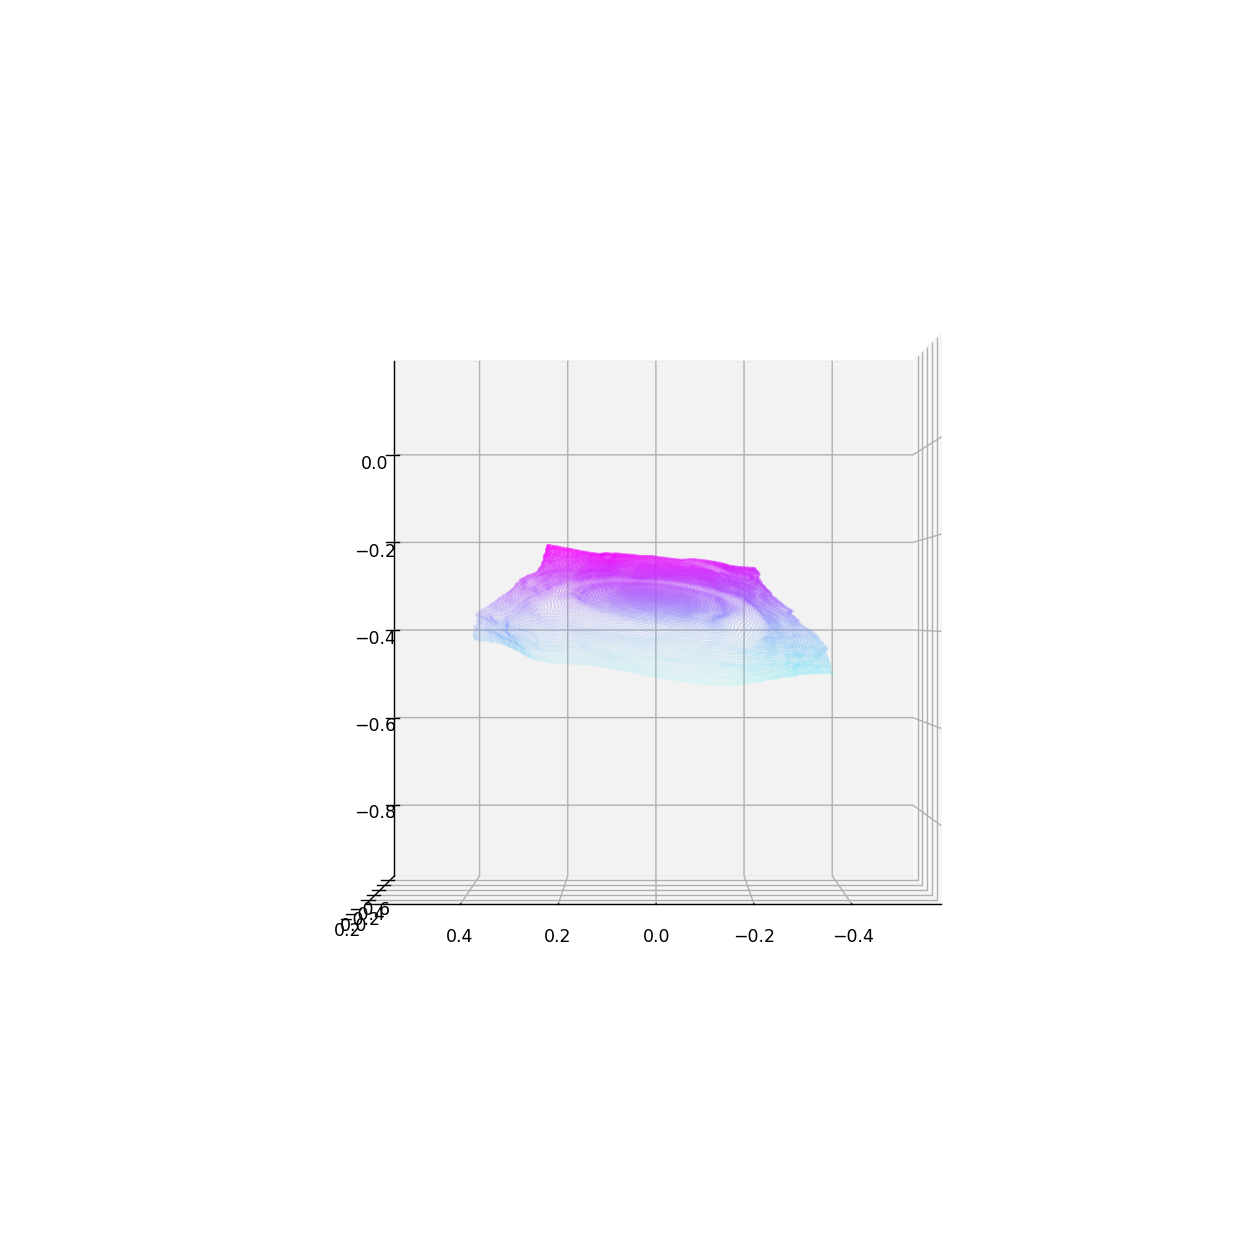

<IPython.core.display.Javascript object>


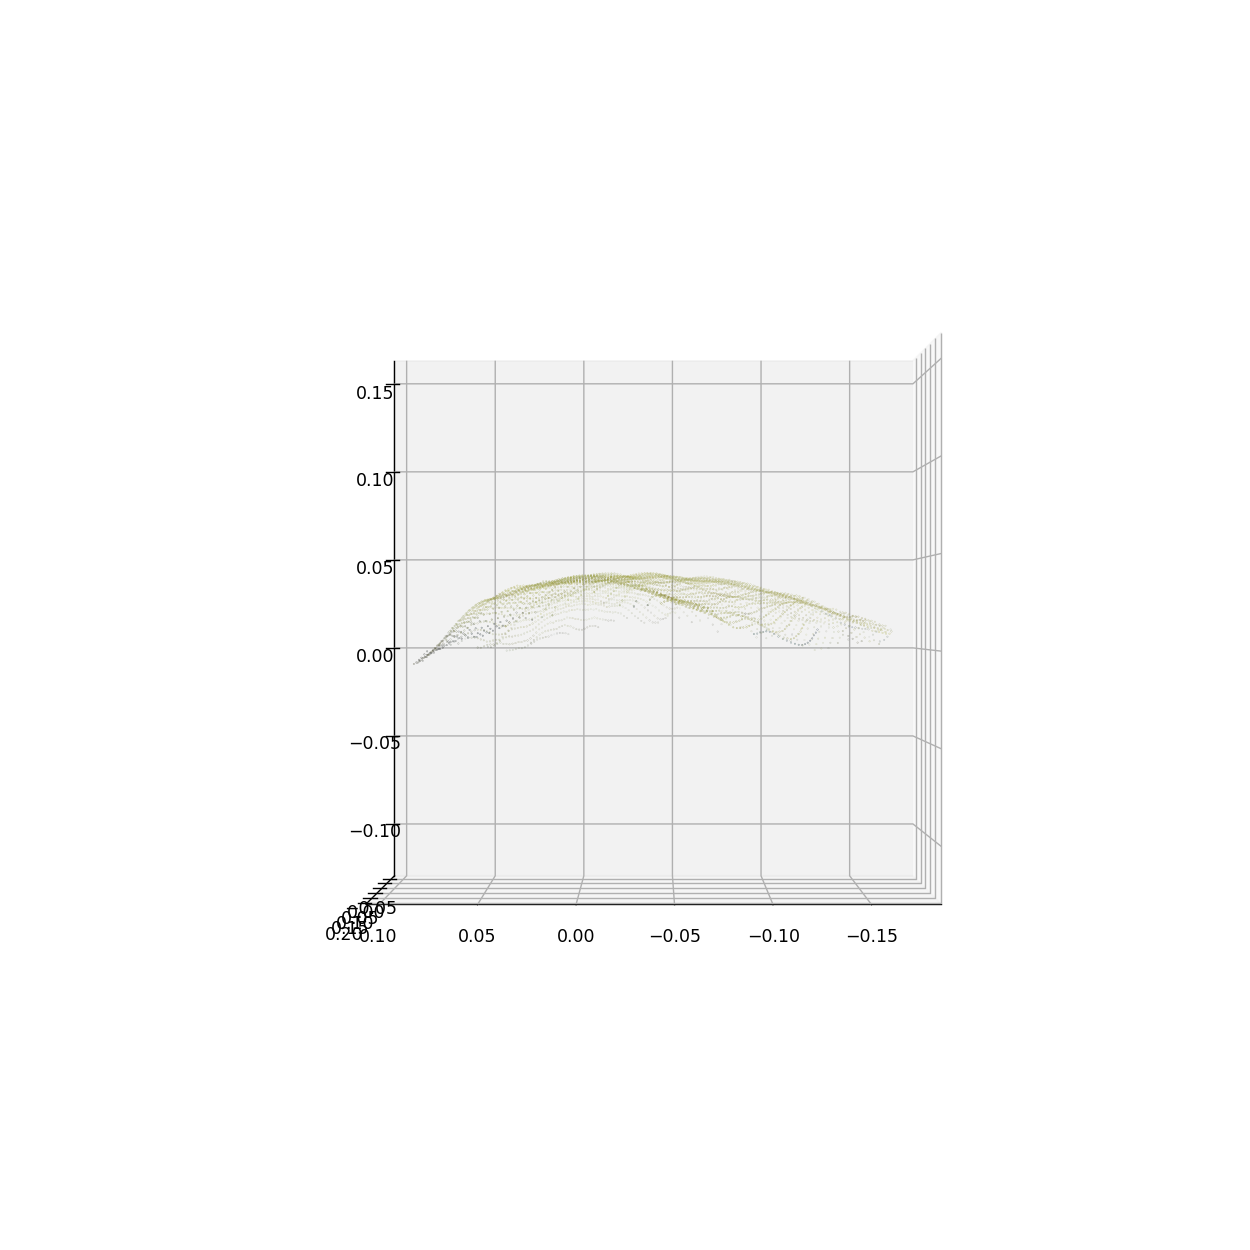

<IPython.core.display.Javascript object>


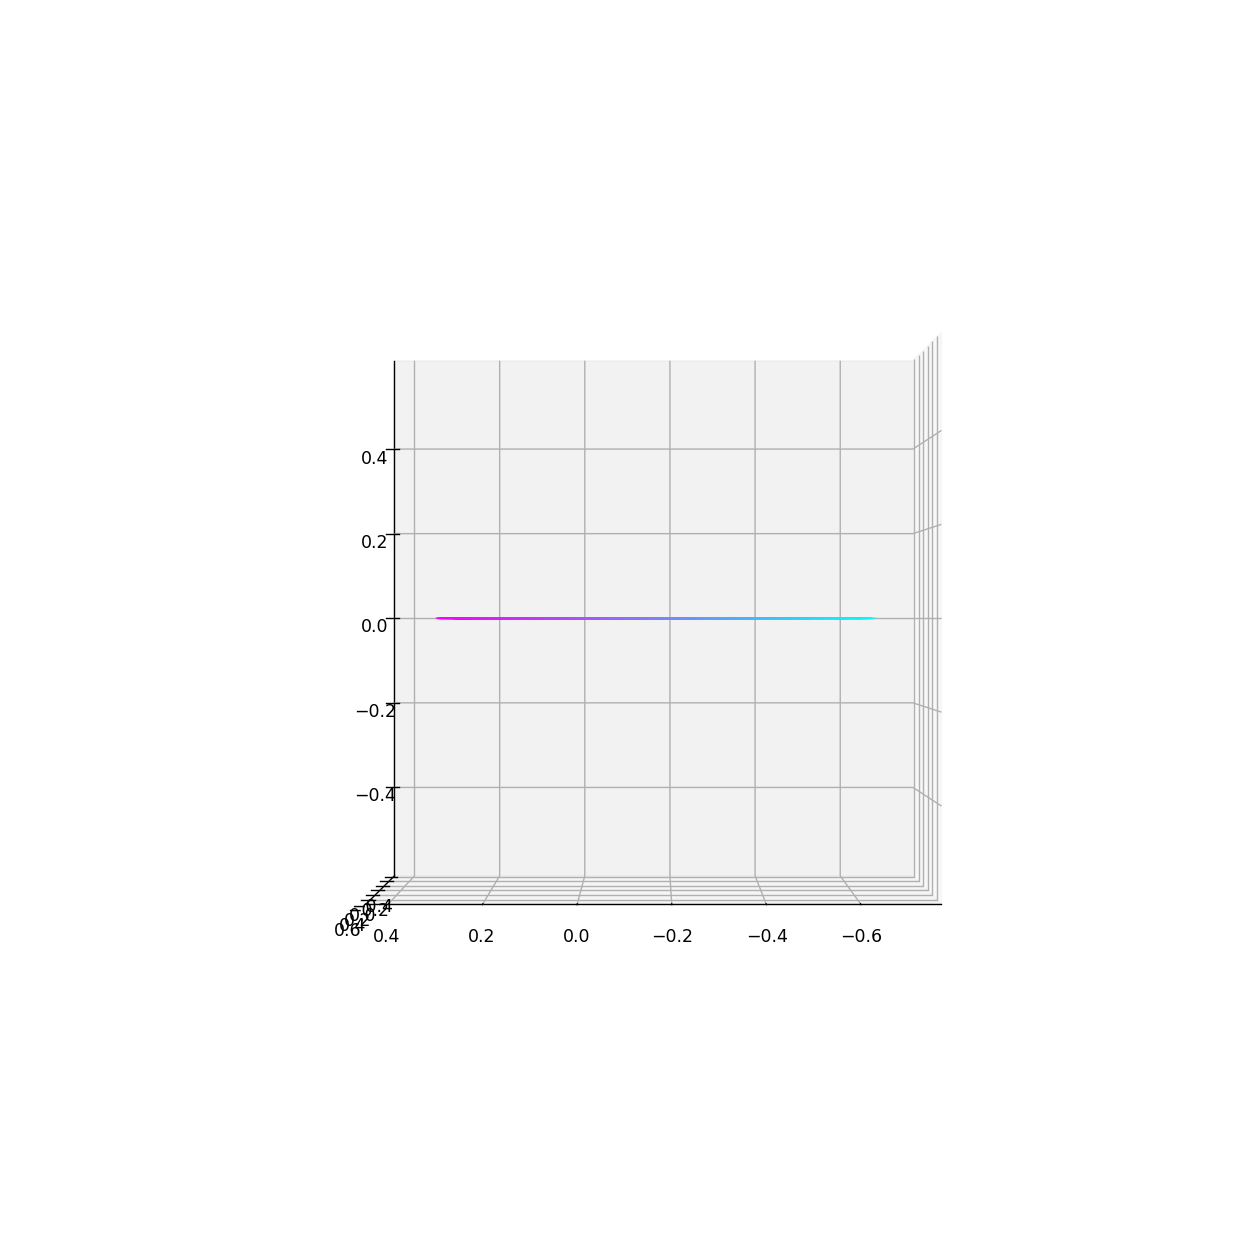

<IPython.core.display.Javascript object>


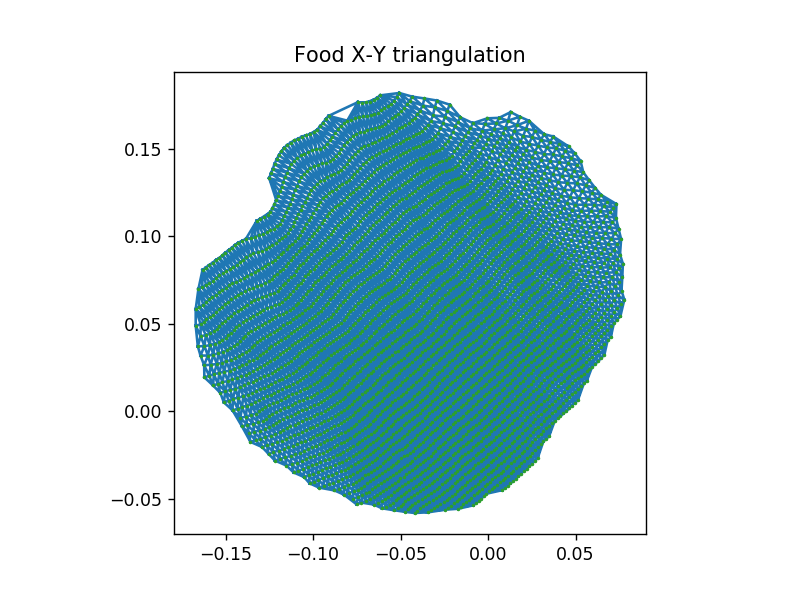

In [6]:
%matplotlib notebook

# Estimate volumes in input image
input_image = r'C:\Users\Bisht\OneDrive\Desktop\python\volume_estimation\assets\readme_assets\examples\food_chachiya_image.jpg'
plate_diameter = 0.35 # Set as 0 to ignore plate detection and scaling
outputs_list = estimator.estimate_volume(input_image, fov=70, plate_diameter_prior=plate_diameter, 
                                         plot_results=True)

# Plot results for all detected food objects
for outputs in outputs_list:
    (estimated_volume, object_points_df, non_object_points_df, plane_points_df, object_points_transformed_df, 
        plane_points_transformed_df, simplices) = outputs
    fig = plt.gcf()
    fig.set_size_inches(6.5, 5.3)
    
    # Flip x and z coordinates to match point cloud with plotting axes
    object_points_df.values[:,0] *= -1
    object_points_df.values[:,2] *= -1
    non_object_points_df.values[:,0] *= -1
    non_object_points_df.values[:,2] *= -1
    plane_points_df.values[:,0] *= -1
    plane_points_df.values[:,2] *= -1
    
    # Create point cloud objects and plot
    object_pc = PyntCloud(object_points_df)
    non_object_pc = PyntCloud(non_object_points_df)
    plane_pc = PyntCloud(plane_points_df)
    scene = object_pc.plot(initial_point_size=0.005, return_scene=True)
    non_object_pc.plot(initial_point_size=0.005, scene=scene)
    plane_pc.plot(initial_point_size=0.001, use_as_color='z', cmap='cool', scene=scene)
    
    # Create transformed point clouds and plot
    plane_transformed_pc = PyntCloud(plane_points_transformed_df)
    object_transformed_pc = PyntCloud(object_points_transformed_df)
    scene = object_transformed_pc.plot(initial_point_size=0.005, return_scene=True)
    plane_transformed_pc.plot(initial_point_size=0.005, use_as_color='x', cmap='cool', scene=scene)

    # Plot x-y plane triangulation of food object
    volume_points = object_points_transformed_df.values[object_points_transformed_df.values[:,2] > 0]
    plt.figure()
    plt.triplot(volume_points[:,0], volume_points[:,1], simplices)
    plt.plot(volume_points[:,0], volume_points[:,1], 'o', markersize=1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Food X-Y triangulation')

    plt.show()